In [23]:
import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy_from_subses,
    construct_features_sbert_embeddings_from_subses,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_from_session_flatten_masked
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from himalaya.backend import set_backend


from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import split_single_array
from AOTglmsingle.glmoutput_save_nifti import get_affine_matrix
from AOTanalysis.bandedRR.utils import reshape_from_flatten_masked_to_wholebrain
from himalaya.scoring import r2_score

import os

import joblib
import nibabel as nib


sub = 3
trian_ses = 1
test_ses = 1
centered = True
direction = "fw"

model_path = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_based/model_sub{sub}_feature_semantic_trainses_1.joblib"
R2_file = f"/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature_withSTD_session_based/R2_score_single_sub{sub}_semantic_train_1_test_2.nii.gz"

model = joblib.load(model_path)

glmsingle_access = GLMSingleAccess()
stimuli_info_access = StimuliInfoAccess()


def mask_construct(R2_file, threshold=0.15):
    R2 = nib.load(R2_file).get_fdata()
    mask = np.zeros_like(R2)
    mask[R2 > threshold] = 1
    return mask


test_video_betas = construct_target_data_from_session_flatten_masked(sub=sub,ses=test_ses,centered=centered,mask_threshold=0.15)

print(f"Shape of test_video_betas: {test_video_betas.shape}")  # (360,641846)
len_test = test_video_betas.shape[0]
list_of_test_video_betas_glm = [test_video_betas[i] for i in range(len_test)]
list_of_test_video_betas_glm_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(list_of_test_video_betas_glm[i], sub=sub)
    for i in range(len_test)
]
print(
    f"len of list_of_test_video_betas_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

test_X = construct_features_sbert_embeddings_from_subses(sub=sub, ses=test_ses, centered=centered)
print(f"Shape of test_X: {test_X.shape}")

Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_02_run_01.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_02_run_02.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_02_run_03.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_02_run_04.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_02_run_05.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/aot/data/experiment/settings/main/experiment_settings_sub_03_ses_02_run_06.yml
Loaded expdesign from /tank/zhangs/AOT_code_repos/arrow_of_time_experiment/a

In [24]:
print(f"Shape of test_X: {test_X.shape}")
print(
    f"len of list_of_test_video_betas_glm_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_glm_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

Shape of test_X: (720, 768)
len of list_of_test_video_betas_glm_wholebrain: 720
Shape of list_of_test_video_betas_glm_wholebrain[0]: (84, 95, 106)


In [25]:
from himalaya.backend import set_backend

set_backend("torch_cuda", on_error="warn")
#set_backend("numpy")
test_X = np.array(test_X)
model_predictions = model.predict(test_X)

print(f"Shape of model_predictions: {model_predictions.shape}")

Shape of model_predictions: torch.Size([720, 344817])


In [26]:
model_predictions = np.array(model_predictions)
print(f"Shape of model_predictions: {model_predictions.shape}")
len_test = model_predictions.shape[0]
list_of_model_predictions_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(model_predictions[i], sub)
    for i in range(len_test)
]
print(
    f"len of list_of_model_predictions_wholebrain: {len(list_of_model_predictions_wholebrain)}"
)


Shape of model_predictions: (720, 344817)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Shape of R2 mask: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Shape of R2 mask: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
Shape of R2: (84, 95, 106)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp_newpreproc/sub-003_ses-01_T1W_nordicstc_1.7mm/TYPED_FITHRF_GLMDENOISE_RR/R2.nii.gz
S

In [27]:
def mask_and_flatten_list_of_data(list_of_data, mask):
    masked_data = [data[mask == 1] for data in list_of_data]
    flattened_masked_data = [data.flatten() for data in masked_data]
    return flattened_masked_data



In [28]:
prediction_R2_mask = mask_construct(R2_file)
print(f"Shape of prediction_R2_mask: {prediction_R2_mask.shape}")


flatten_and_masked_model_predictions = mask_and_flatten_list_of_data(
    list_of_model_predictions_wholebrain, prediction_R2_mask
)

flatten_and_masked_test_video_betas_glm = mask_and_flatten_list_of_data(
    list_of_test_video_betas_glm_wholebrain, prediction_R2_mask
)

print(
    f"Shape of flatten_and_masked_model_predictions: {flatten_and_masked_model_predictions[0].shape}"
)

print(
    f"Shape of flatten_and_masked_test_video_betas_glm: {flatten_and_masked_test_video_betas_glm[0].shape}"
)   


# L2 normalization both model_predictions and test_video_betas
# from sklearn.preprocessing import Normalizer

# normalizer = Normalizer()
# normalizer.fit(flatten_and_masked_model_predictions)
# flatten_and_masked_model_predictions = normalizer.transform(
#     flatten_and_masked_model_predictions
# )
# flatten_and_masked_test_video_betas_glm = normalizer.transform(
#     flatten_and_masked_test_video_betas_glm
# )

# pick the first n data
# n = 500
# flatten_and_masked_model_predictions = flatten_and_masked_model_predictions[:n]
# flatten_and_masked_test_video_betas_glm = flatten_and_masked_test_video_betas_glm[:n]

Shape of prediction_R2_mask: (84, 95, 106)
Shape of flatten_and_masked_model_predictions: (580,)
Shape of flatten_and_masked_test_video_betas_glm: (580,)


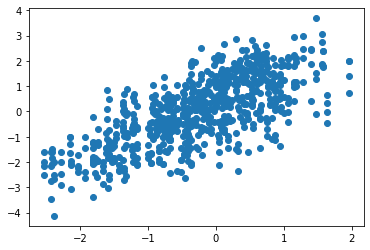

In [29]:
import seaborn as sns
# sns.heatmap(flatten_and_masked_model_predictions)
import matplotlib.pyplot as plt
plt.plot(
    np.array(flatten_and_masked_model_predictions).mean(1),
    np.array(flatten_and_masked_test_video_betas_glm).mean(1),
    "o",
)

In [30]:
# for each prediction, get the most similar betas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances


def get_most_similar_beta(prediction, betas,metric_func=cosine_similarity):
    similarity = metric_func([prediction], betas)
    most_similar_index = np.argmax(similarity)
    return most_similar_index


most_similar_betas = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas: {len(most_similar_betas)}")
print(f"most_similar_betas: {most_similar_betas}")


# pearsonr from sklearn


most_similar_betas_euclidean = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=euclidean_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_euclidean: {len(most_similar_betas_euclidean)}")
print(f"most_similar_betas_euclidean: {most_similar_betas_euclidean}")

most_similar_betas_manhattan = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=manhattan_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_manhattan: {len(most_similar_betas_manhattan)}")
print(f"most_similar_betas_manhattan: {most_similar_betas_manhattan}")

most_similar_betas_cosine = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=cosine_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_cosine: {len(most_similar_betas_cosine)}")
print(f"most_similar_betas_cosine: {most_similar_betas_cosine}")




Shape of most_similar_betas: 720
most_similar_betas: [350, 45, 189, 138, 189, 287, 276, 555, 469, 423, 350, 412, 445, 45, 287, 556, 384, 562, 262, 189, 555, 445, 287, 242, 356, 445, 384, 138, 72, 297, 351, 82, 630, 390, 138, 256, 68, 287, 236, 257, 222, 72, 138, 124, 350, 82, 82, 587, 256, 45, 630, 350, 562, 351, 262, 256, 287, 256, 287, 287, 553, 351, 445, 423, 562, 72, 445, 236, 256, 256, 236, 351, 584, 256, 287, 139, 163, 138, 394, 287, 394, 287, 469, 445, 351, 555, 163, 445, 562, 445, 256, 432, 276, 633, 356, 63, 442, 256, 384, 351, 351, 256, 82, 555, 356, 356, 287, 82, 68, 587, 88, 652, 562, 394, 628, 351, 562, 45, 390, 214, 445, 61, 447, 630, 413, 445, 72, 587, 442, 287, 432, 469, 562, 556, 189, 432, 562, 562, 82, 256, 256, 257, 445, 256, 139, 82, 584, 138, 139, 222, 276, 562, 432, 256, 45, 394, 447, 222, 413, 82, 555, 374, 287, 555, 45, 390, 351, 351, 63, 445, 63, 445, 88, 139, 72, 139, 79, 390, 45, 63, 469, 88, 562, 242, 394, 236, 45, 356, 45, 287, 45, 72, 351, 82, 214, 138, 35

Shape of most_similar_betas_cosine: 720
most_similar_betas_cosine: [385, 524, 304, 184, 463, 87, 520, 634, 385, 87, 385, 445, 412, 524, 282, 28, 100, 385, 541, 304, 11, 412, 282, 312, 315, 412, 100, 318, 418, 100, 708, 385, 87, 520, 54, 634, 110, 495, 87, 385, 634, 99, 597, 385, 385, 385, 385, 634, 634, 524, 87, 385, 385, 495, 541, 626, 478, 626, 445, 10, 711, 415, 412, 315, 385, 99, 412, 463, 358, 634, 12, 708, 385, 634, 478, 634, 11, 376, 444, 315, 445, 100, 385, 464, 415, 634, 11, 385, 385, 464, 634, 118, 546, 507, 315, 440, 385, 634, 100, 176, 708, 634, 385, 634, 315, 478, 100, 385, 110, 621, 376, 33, 385, 443, 524, 634, 385, 318, 708, 110, 412, 415, 220, 87, 545, 63, 418, 634, 385, 478, 118, 385, 385, 28, 463, 118, 385, 385, 385, 634, 634, 385, 63, 358, 634, 385, 385, 184, 634, 99, 282, 385, 118, 524, 318, 443, 220, 99, 545, 385, 385, 415, 282, 626, 545, 634, 634, 415, 478, 385, 440, 412, 184, 634, 418, 634, 706, 520, 634, 478, 385, 376, 385, 312, 445, 478, 385, 315, 318, 282, 545

In [31]:
from scipy.stats import pearsonr


def scores_for_a_prediction(prediction,betas):
    scores = [pearsonr(prediction,beta)[0] for beta in betas]
    return scores


def get_most_similar_beta_corr(prediction, betas):
    scores = scores_for_a_prediction(prediction,betas)
    most_similar_index = np.argmax(scores)
    return most_similar_index

most_similar_betas_corr = [get_most_similar_beta_corr(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_corr: {len(most_similar_betas_corr)}")
print(f"most_similar_betas_corr: {most_similar_betas_corr}")

Shape of most_similar_betas_corr: 720
most_similar_betas_corr: [350, 45, 189, 138, 508, 287, 351, 256, 628, 423, 350, 394, 445, 45, 327, 556, 384, 562, 115, 189, 555, 445, 351, 139, 356, 445, 384, 138, 115, 297, 107, 375, 351, 390, 555, 256, 68, 287, 236, 163, 72, 244, 138, 124, 350, 584, 82, 256, 256, 256, 351, 350, 163, 351, 115, 256, 287, 256, 287, 287, 553, 351, 82, 423, 562, 244, 445, 236, 256, 256, 236, 351, 256, 256, 351, 139, 163, 138, 394, 351, 394, 115, 628, 445, 351, 555, 163, 350, 163, 445, 256, 115, 276, 633, 356, 262, 413, 256, 384, 351, 351, 256, 82, 256, 356, 356, 115, 82, 68, 610, 592, 652, 562, 394, 628, 351, 562, 163, 633, 214, 445, 351, 447, 351, 413, 350, 107, 256, 413, 351, 115, 628, 562, 556, 508, 115, 562, 163, 82, 256, 139, 163, 350, 256, 139, 584, 256, 138, 139, 222, 276, 562, 115, 256, 163, 394, 447, 222, 413, 375, 555, 587, 327, 256, 163, 390, 139, 351, 63, 350, 262, 445, 469, 139, 115, 139, 351, 390, 45, 63, 413, 592, 562, 139, 394, 287, 413, 356, 163, 351,

Shape of similarity_matrix: (720, 720)


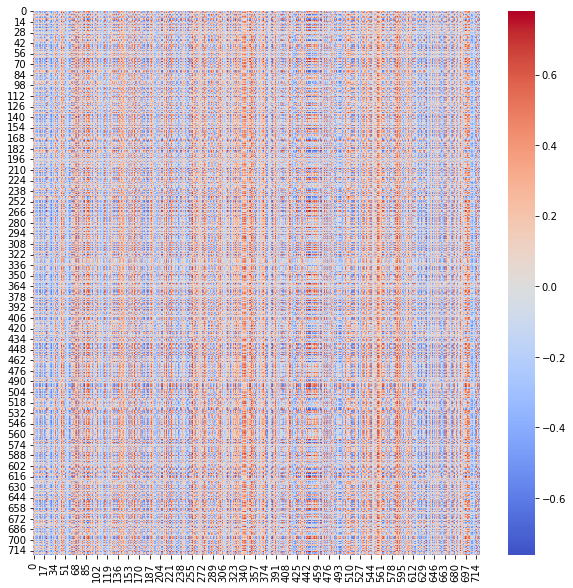

In [32]:
# draw a picture to show the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

similarity_matrix = [scores_for_a_prediction(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]

similarity_matrix = similarity_matrix
similarity_matrix = np.array(similarity_matrix)



print(f"Shape of similarity_matrix: {similarity_matrix.shape}")
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix, cmap="coolwarm", center=0)
plt.show()